<a href="https://colab.research.google.com/github/MansiPandey-2002/Emotion-Detection-using-Deep-Learning/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing the necessary tools
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import numpy as np
import os
from matplotlib import pyplot as plt
from IPython.display import Image
from sklearn.model_selection import train_test_split

In [ ]:
#!unzip "drive/MyDrive/archive_2.0.zip" -d "drive/MyDrive/EmotionDetection/"

# Preprocessing images

In [ ]:
def load_and_preprocess_images(dataset_path, image_size=(224, 224)):
    images = []
    labels = []

    emotion_mapping = {
        'angry': 0,
        'disgusted': 1,
        'fearful': 2,
        'happy': 3,
        'neutral': 4,
        'sad': 5,
        'surprised': 6
    }

    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)

        if os.path.isdir(subfolder_path) and subfolder in emotion_mapping:
            label = emotion_mapping[subfolder]
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)


                # Extracting emotion
                emotion_from_path = os.path.basename(subfolder_path)
                #label_from_path = emotion_mapping.get(emotion_from_path, None)


                """if label_from_path is not None:
                    # Load and preprocess the image
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, image_size)
                    img = img / 255.0  # Normalize pixel values to the range [0, 1]"""

                images.append(img_path)
                labels.append(emotion_from_path)

    return np.array(images), np.array(labels)

dataset_path = 'drive/MyDrive/EmotionDetection/train'
filenames, labels = load_and_preprocess_images(dataset_path)



In [ ]:
from sklearn.preprocessing import LabelBinarizer #Changing categorical emotions to binary vectors for nn training
# Initialize
label_binarizer = LabelBinarizer()

# Fit and transform the labels
boolean_labels = label_binarizer.fit_transform(labels)

In [ ]:
x=filenames
y=boolean_labels
num_images= 1000 #@param{type:"slider",min:1000,max:20000,step:100}

In [ ]:
x_train,x_val,y_train,y_val=train_test_split(x[:num_images],y[:num_images],test_size=0.2,random_state=42)
len(x_train),len(y_train),len(x_val),len(y_val)

(800, 800, 200, 200)

In [ ]:
IMG_SIZE=224
def process_image(image_path,img_size=IMG_SIZE):
  image=tf.io.read_file(image_path)
  image=tf.image.decode_png(image,channels=3) #3 colors
  image=tf.image.convert_image_dtype(image,tf.float32)
  image=tf.image.resize(image,size=[img_size,img_size])
  return image

def get_image_label(image_path,label):
  image=process_image(image_path)
  return image,label


## Creating batches for training, validation and testing

In [ ]:
BATCH_SIZE = 32

def create_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    if test_data:
        print("Creating test data batches")
        data = tf.data.Dataset.from_tensor_slices(tf.constant(x))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
    elif valid_data:
        print("Creating validation batches")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    else:
        print("Creating training batches")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data = data.shuffle(buffer_size=len(x))
        data = data.map(get_image_label)
        data_batch = data.batch(BATCH_SIZE)
        return data_batch

In [ ]:
train_data = create_batches(x_train, y_train)
val_data = create_batches(x_val, y_val, valid_data=True)

Creating training batches
Creating validation batches


In [ ]:
unique_labels=np.unique(labels)
INPUT_SHAPE=[IMG_SIZE,IMG_SIZE,3]
OUTPUT_SHAPE=len(unique_labels)

In [ ]:
#Out of mobilenetv2, VGG16 , ResnNet50, resnet performs best

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
    # Loading the model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

    # Build the new model on top of the pre-trained ResNet50
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(224, activation='relu'),
        tf.keras.layers.Dense(output_shape, activation='softmax')
    ])

    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    return model



model = create_model()
model.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 224)               458976    
                                                                 
 dense_1 (Dense)             (None, 7)                 1575      
                                                                 
Total params: 24048263 (91.74 MB)
Trainable params: 23995143 (91.53 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
%load_ext tensorboard
import datetime
def tensor_callback():
  log = os.path.join("drive/MyDrive/EmotionDetection/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(log)

# Preventing overfittings and generalisation
early_stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

In [ ]:
NUM_EPOCHS=30 #@param{type:"slider",min:10,max:200,step:5}

In [ ]:
# Function to train model and fit to data
# This function can be used to test if model works on small data(validation and test set)
def train_model():
    model = create_model()
    tensorboard = tensor_callback()  # Note the parentheses here
    model.fit(x=train_data,
              epochs=NUM_EPOCHS,
              validation_data=val_data,
              validation_freq=1,
              callbacks=[tensorboard, early_stop])
    return model


In [ ]:
#model=train_model()  # Training smaller data of 1000 images...accuracy=1

# Predictions


In [ ]:
#predictions = model.predict(val_data, verbose=1)

In [ ]:
def get_pred_label(prediction_prob):
  return unique_labels[np.argmax(prediction_prob)]

In [ ]:
def unbatch_data(data):   #to get labels and images out
  images=[]
  labels=[]
  for image,label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_labels[np.argmax(label)])
  return images,labels

val_images,val_labels=unbatch_data(val_data)

In [ ]:
def predict(prediction_prob,labels,images,n=0):
  pred_prob,true_label,image=prediction_prob[n],labels[n],images[n]
  pred_label=get_pred_label(pred_prob)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  if pred_label==true_label:
    color="green"
  else:
    color="red"
  plt.title("{}: {:.2%}, True Label: {}".format(pred_label, np.max(pred_prob), true_label),color=color)
  plt.show()


In [ ]:
full_data=create_batches(x,y)
full_model=create_model()
full_model_tensorboard=tensor_callback()
#no validation set when training all data
full_model_early_stop=tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=4)

Creating training batches


In [ ]:
"""full_model.fit(x=full_data,
            epochs=NUM_EPOCHS,
            callbacks=[full_model_tensorboard,full_model_early_stop])"""

'full_model.fit(x=full_data,\n            epochs=NUM_EPOCHS,\n            callbacks=[full_model_tensorboard,full_model_early_stop])'

In [ ]:
#saving model
def save_model(model,suffix=None):
  modeldir=os.path.join("drive/MyDrive/EmotionDetection/models", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path=modeldir+"-"+suffix+".h5"
  print(f"Saving model to {model_path}")
  model.save(model_path)
  return model_path

#loading model function
def load_model(model_path):
  print(f"Loading model from {model_path}")
  model=tf.keras.models.load_model(model_path,custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
save_model(model, suffix="First-1000-Resnet")

Saving model to drive/MyDrive/EmotionDetection/models/20240113-092928-First-1000-Resnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'drive/MyDrive/EmotionDetection/models/20240113-092928-First-1000-Resnet.h5'

In [ ]:
save_model(full_model, suffix="full-data-Resnet-Adam")

Saving model to drive/MyDrive/EmotionDetection/models/20240113-092929-full-data-Resnet-Adam.h5


'drive/MyDrive/EmotionDetection/models/20240113-092929-full-data-Resnet-Adam.h5'

In [ ]:
loaded_full_model=load_model('drive/MyDrive/EmotionDetection/models/20231125-182502-full-data-Resnet-Adam.h5')

Loading model from drive/MyDrive/EmotionDetection/models/20231125-182502-full-data-Resnet-Adam.h5


# Test Data

In [ ]:
test_path="drive/MyDrive/EmotionDetection/test"
test_filenames,test_labels=load_and_preprocess_images(test_path)

In [ ]:
# Creating batches for test data

In [ ]:
test_data=create_batches(test_filenames,test_data=True)

Creating test data batches


In [ ]:
"""test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)"""

'test_predictions = loaded_full_model.predict(test_data,\n                                             verbose=1)'

In [ ]:
# Saving predictions to csv file
"""np.savetxt("drive/MyDrive/EmotionDetection/predic_arr.csv", test_predictions, delimiter=",")"""

'np.savetxt("drive/MyDrive/EmotionDetection/predic_arr.csv", test_predictions, delimiter=",")'

In [ ]:
test_predictions = np.loadtxt("drive/MyDrive/EmotionDetection/predic_arr.csv", delimiter=",")


## Making predictions on custom images



In [ ]:
custom_path = "drive/MyDrive/EmotionDetection/Photos/"
exclude_dirs = ['.ipynb_checkpoints']
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path) if fname not in exclude_dirs]
custom_image_paths

custom_data = create_batches(custom_image_paths, test_data=True)
custom_preds = loaded_full_model.predict(custom_data)

custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

Creating test data batches
1/1 [==============================] - 2s 2s/step


['angry', 'surprised', 'happy']

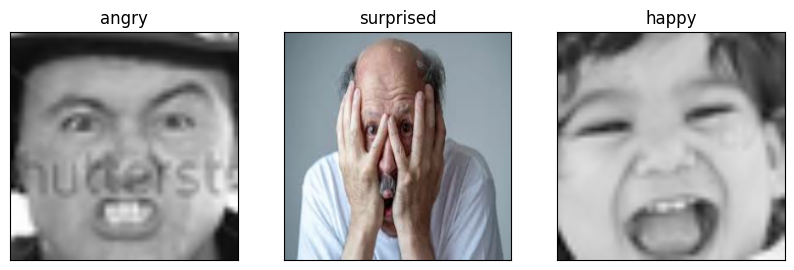

In [ ]:
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

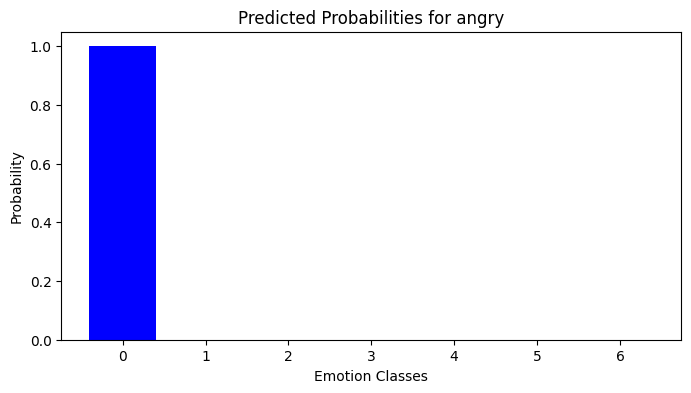

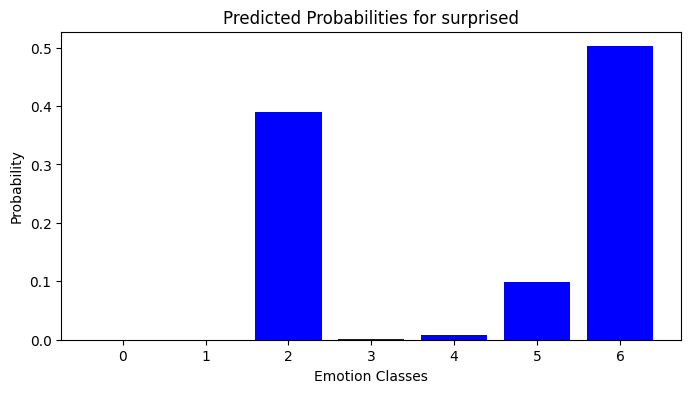

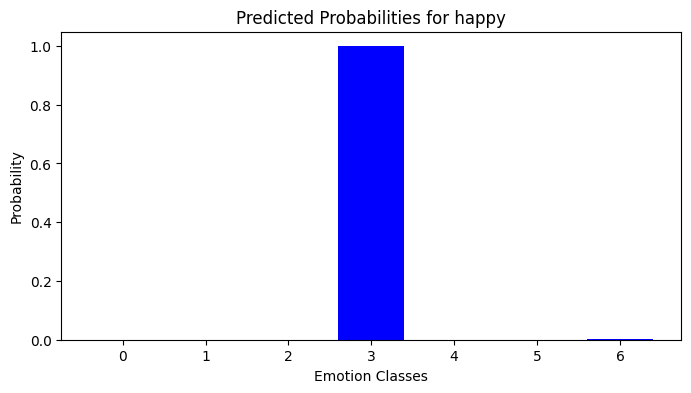

In [ ]:
for i in range(len(custom_pred_labels)):
    plt.figure(figsize=(8, 4))

    classes = range(len(custom_preds[i]))
    probabilities = custom_preds[i]

    plt.bar(classes, probabilities, color='blue')
    plt.xlabel('Emotion Classes')
    plt.ylabel('Probability')
    plt.title(f'Predicted Probabilities for {custom_pred_labels[i]}')
    #plt.xticks(classes, custom_pred_labels[i], rotation=45, ha='right', fontsize=8)


    plt.show()